<a href="https://colab.research.google.com/github/DarwinFer/Burgers1D_PD/blob/main/E2Burges1DPINNvsSOLEXACTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejemplo 2:   PINNs vs Solición exacta

A continuacion presentamos un ejemplo  que ilustra el enfoques PINNs, en el ejemplo particular de un problema directo asociado a la la Ecuación de Burges viscosa en una dimensión.

La formulación matemática es la siguiente:

$$
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},
$$
Para  $(x,t) \in (0,1)\times(0,1]$. Sujera a la condición inicial,

 $$
 u(x,0) = u_{0}(x), \qquad  x \in [-1,1],
 $$

 y a condiciones de forntera tipo Dirichlet,
$$
u(t,0) = u(t,1) = 0, \qquad  t \in [0,T]
$$


Aquí, $\nu > 0$ representa la viscosidad cinemática del medio  y la condición  $u(x,0) = u_{0} (\cdot)$ define un perfil el instante inicial

##Enfoque Redes Neuronales Informadas po la Física  (PINNs)

> Deseamos resolver el problema directo definido anteriormente mediante una red neuronal informada por la fisica, para ello incorporamos la estructura física del problema definiendo la siguiente función de péridida total
$$ \mathcal{L}(\theta) =  \lambda_{ic}   \mathcal{L}_{\text{ic}} + \lambda_{bc} \mathcal{L}_{\text{bc}} + \lambda_{r} \mathcal{L}_{r}  $$

donde
$\mathcal{L}_{\text{r}} = \frac{1}{N_r} \sum_{i=1}^{N_r} \left| \underbrace{\frac{\partial \hat{u}}{\partial t} + \hat{u} \frac{\partial \hat{u}}{\partial x} - \nu \frac{\partial^2 \hat{u}}{\partial x^2}}_{\mathcal{R}_{\theta}}   \right|^2,$ $\mathcal{L}_{\text{IC}} = \frac{1}{N_0} \sum_{i=1}^{N_0} \left| \hat{u}(x_i,0) - u_0(x_i) \right|^2, $
  y $ \mathcal{L}_{\text{BC}} = \frac{1}{N_b} \sum_{i=1}^{N_b} \left( \left| \hat{u}(0,t_i) \right|^2 + \left| \hat{u}(1,t_i)  \right|^2 \right).$ Representan la perdida residual de la EDP, la perdida en la condición inicial y en la frontera respectivamente.  Debido a que en este experimento deseamos analizar el potencial de las tecnicas antes mencionadas, elegimos una condición inicial $u_{0}(x)$ la cual conocemos apriori que proviene de una solución exacta. De modo que consideramos
  $$
u_{0} (x) = \frac{2\nu \pi \sin(\pi x)}{\sigma + \cos(\pi x)},	\qquad \sigma  > 1.
  $$
Los parametros ultilizamos para este experimento son  $\nu= \frac{1}{100}\pi$ y $\sigma= 1,5$.

In [ ]:
#Importamos las librerias necesarias
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

> Comenzamos definiendo la solución exacta y la condición inicial. Luego creamos la red neuronal con 2 entradas $(x,t)$, tres capas oculpas y 50 neuronas por cada capa, una única capa de salida que devuelve el valor $\hat{u}(x,t)$


In [ ]:


# Parámetros
nu = 1 / (100 * np.pi)
sigma = 1.5

# Solución exacta u(x,t)
def exact_solution(x, t, nu=nu, sigma=sigma):
    pi = np.pi
    exp_term = np.exp(-pi**2 * nu * t)
    numerator = 2 * pi * nu * exp_term * np.sin(pi * x)
    denominator = sigma + exp_term * np.cos(pi * x)
    return numerator / denominator

# Condición inicial a partir de la solución exacta
x_initial_np = np.linspace(-1, 1, 200).reshape(-1, 1)
u_initial_np = exact_solution(x_initial_np, 0.0)

x_initial = torch.tensor(x_initial_np, dtype=torch.float32)
t_initial = torch.zeros_like(x_initial)
u_initial = torch.tensor(u_initial_np, dtype=torch.float32)

# Red PINN
class BurgersPINN(nn.Module):
    def __init__(self):
        super(BurgersPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat((x, t), dim=1))

model = BurgersPINN()

# Datos internos, frontera
n_interior = 10000
x_interior = torch.rand(n_interior, 1) * 2 - 1
t_interior = torch.rand(n_interior, 1)
x_interior.requires_grad = True
t_interior.requires_grad = True

n_boundary = 400
t_boundary = torch.linspace(0, 1, n_boundary).reshape(-1, 1)
x_boundary_left = -torch.ones_like(t_boundary)
x_boundary_right = torch.ones_like(t_boundary)
u_boundary_left = torch.zeros_like(t_boundary)
u_boundary_right = torch.zeros_like(t_boundary)
#parametros
lambda1, lambda2, lambda3 = 1,1,1
# Función de pérdida
def loss_function(model, x_interior, t_interior, x_initial, t_initial, u_initial,
                  x_boundary_left, x_boundary_right, t_boundary, u_boundary_left, u_boundary_right):
    u = model(x_interior, t_interior)
    u_t = torch.autograd.grad(u, t_interior, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_interior, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, torch.ones_like(u_x), create_graph=True)[0]
    f = u_t + u * u_x - nu * u_xx
    loss_pde = torch.mean(f**2)

    u_i = model(x_initial, t_initial)
    loss_ic = torch.mean((u_i - u_initial)**2)

    u_bl = model(x_boundary_left, t_boundary)
    u_br = model(x_boundary_right, t_boundary)
    loss_bc = torch.mean((u_bl - u_boundary_left)**2) + torch.mean((u_br - u_boundary_right)**2)

    return lambda1*loss_pde + lambda2*loss_ic + lambda3*loss_bc

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_interior, t_interior, x_initial, t_initial, u_initial,
                         x_boundary_left, x_boundary_right, t_boundary, u_boundary_left, u_boundary_right)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")



Epoch 0, Loss: 1.17e-02
Epoch 500, Loss: 1.39e-04
Epoch 1000, Loss: 3.26e-05
Epoch 1500, Loss: 5.75e-05
Epoch 2000, Loss: 1.32e-05
Epoch 2500, Loss: 2.00e-05
Epoch 3000, Loss: 5.53e-05
Epoch 3500, Loss: 1.20e-05
Epoch 4000, Loss: 1.31e-04
Epoch 4500, Loss: 1.18e-05
Epoch 5000, Loss: 1.17e-05
Epoch 5500, Loss: 1.16e-05
Epoch 6000, Loss: 1.17e-05
Epoch 6500, Loss: 1.15e-05
Epoch 7000, Loss: 1.22e-05
Epoch 7500, Loss: 1.14e-05
Epoch 8000, Loss: 1.16e-05
Epoch 8500, Loss: 1.13e-05
Epoch 9000, Loss: 1.16e-05
Epoch 9500, Loss: 1.12e-05


>graficar 2D

A continuacion expresamos los resultados de diferente manera en 2D  

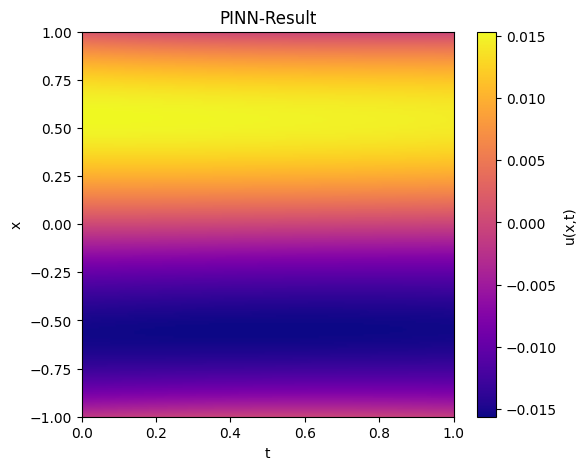

In [ ]:
# ------------------------------------------------------------
# Gráfico 2-D estilo “(b) PINN-Result”
# ------------------------------------------------------------
# Densidad de la malla
n_x, n_t = 200, 200           # puedes aumentarlos para más resolución

# Mallado (x,t)  →  X.shape = (n_x, n_t),  T.shape = (n_x, n_t)
x_grid = torch.linspace(-1, 1, n_x).reshape(-1, 1)
t_grid = torch.linspace(0, 1, n_t).reshape(1,  -1)
X, T   = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')

# Aplanamos y concatenamos para el forward del modelo
XT = torch.cat((X.reshape(-1, 1), T.reshape(-1, 1)), dim=1)
with torch.no_grad():
    U = model(XT[:, 0:1], XT[:, 1:2]).cpu().numpy().reshape(n_x, n_t)

# Plot
plt.figure(figsize=(6, 5))
im = plt.imshow(
    U,
    extent=(0, 1, -1, 1),      # (t_min, t_max, x_min, x_max)
    origin='lower',            # -1 aparece abajo, 1 arriba
    aspect='auto',
    cmap='plasma'              # paleta similar a la del ejemplo
)
plt.xlabel('t')
plt.ylabel('x')
plt.title('PINN-Result')
plt.colorbar(im, label='u(x,t)')
plt.show()



##COMPARACIÓN CON LA SOLUCIÓN EXACTA,  


>En seguida presentamos las implementaciones  para comparar el resultado de la PINN con la solucion exata que para este problema directo es bien conocida.


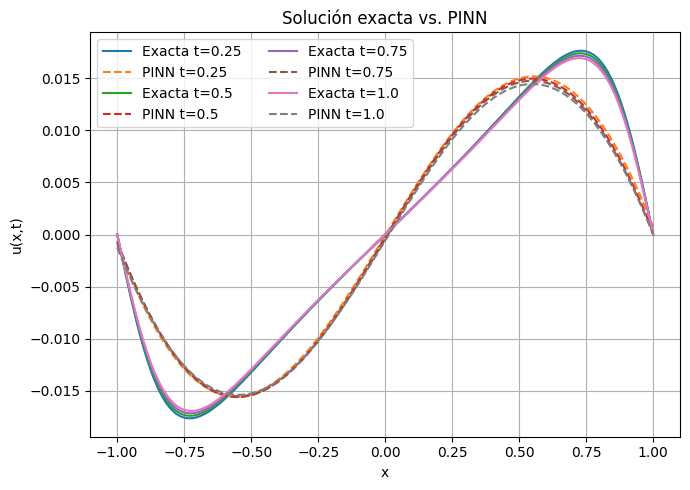

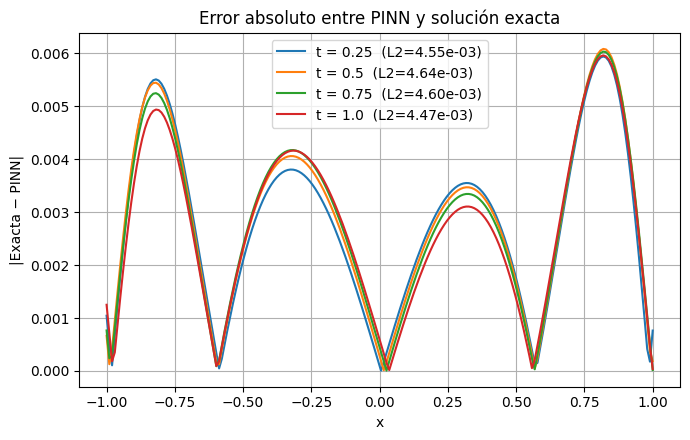


Norma L2 del error (Exacta vs. PINN):
  t = 0.25:   4.548448e-03
  t =  0.5:   4.643353e-03
  t = 0.75:   4.598993e-03
  t =  1.0:   4.466879e-03


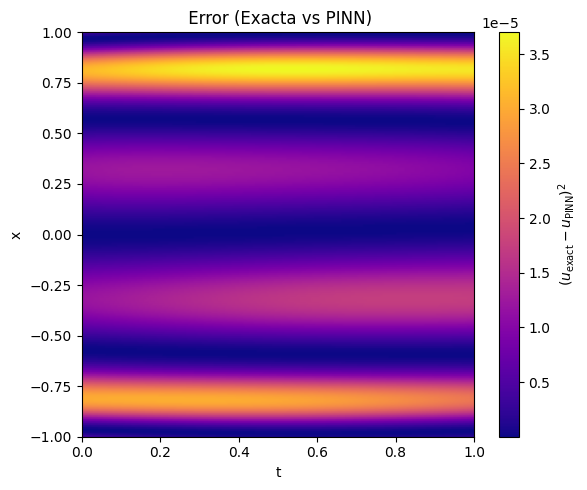

In [ ]:
# ============================================================
# COMPARACIÓN PINN vs. SOLUCIÓN EXACTA
# ============================================================

import torch, numpy as np, matplotlib.pyplot as plt

# ---------- 1. Parámetros y mallas --------------------------
times = [0.25, 0.5, 0.75, 1.0]           # instantes de interés
x_nodes = np.linspace(-1., 1., 200)      # malla de referencia (200 pts)

# ---------- 2. Soluciones y errores puntuales ---------------
exact_solutions = {}
pinn_solutions  = {}
l2_errors       = {}

x_tensor = torch.tensor(x_nodes, dtype=torch.float32).reshape(-1, 1)
with torch.no_grad():
    for t in times:
        # Exacta
        exact_solutions[t] = exact_solution(x_nodes, t)
        # PINN
        t_tensor = torch.full_like(x_tensor, t)
        pinn_solutions[t] = model(x_tensor, t_tensor).cpu().numpy().ravel()
        # Error L2
        err = exact_solutions[t] - pinn_solutions[t]
        dx  = x_nodes[1] - x_nodes[0]
        l2_errors[t] = np.sqrt(np.sum(err**2) * dx)

# ---------- 3. Gráfico 2-D: exacta vs PINN ------------------
plt.figure(figsize=(7, 5))
for t in times:
    plt.plot(x_nodes, exact_solutions[t], label=f'Exacta t={t}')
    plt.plot(x_nodes, pinn_solutions[t], '--', label=f'PINN t={t}')
plt.xlabel('x');  plt.ylabel('u(x,t)')
plt.title('Solución exacta vs. PINN')
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("ExactavsPINNsVariost.pdf", format="pdf")
plt.show()

# ---------- 4. Curvas de error absoluto --------------------
plt.figure(figsize=(7, 4.5))
for t in times:
    abs_err = np.abs(exact_solutions[t] - pinn_solutions[t])
    plt.plot(x_nodes, abs_err, label=f't = {t}  (L2={l2_errors[t]:.2e})')
plt.xlabel('x');  plt.ylabel('|Exacta − PINN|')
plt.title('Error absoluto entre PINN y solución exacta')
plt.legend();  plt.grid(True)
plt.tight_layout()
plt.savefig("CurvasEror.pdf", format="pdf")
plt.show()

#Para obtener los errores
print('\nNorma L2 del error (Exacta vs. PINN):')
for t in times:
    print(f'  t = {t:>4}:   {l2_errors[t]:.6e}')

# ---------- mapa calor 2-D del error cuadrático -----------
# Malla densa (200×200)
n_x, n_t = 200, 200
x_grid = np.linspace(-1., 1., n_x)
t_grid = np.linspace(0., 1., n_t)
Xg, Tg = np.meshgrid(x_grid, t_grid, indexing='ij')

# Evalúa exacta y PINN en toda la rejilla
U_exact = exact_solution(Xg, Tg)
U_pinn  = np.empty_like(Xg)
with torch.no_grad():
    for j, t in enumerate(t_grid):
        t_col = torch.full((n_x, 1), t)
        x_col = torch.tensor(x_grid, dtype=torch.float32).reshape(-1, 1)
        U_pinn[:, j] = model(x_col, t_col).cpu().numpy().ravel()

E2 = (U_exact - U_pinn) ** 2        # error cuadrático

plt.figure(figsize=(6, 5))
im = plt.imshow(
    E2,
    extent=(0, 1, -1, 1),
    origin='lower',
    aspect='auto',
    cmap='plasma'
)
plt.xlabel('t');  plt.ylabel('x')
plt.title(' Error (Exacta vs PINN)')
plt.colorbar(im, label=r'$(u_{\mathrm{exact}} - u_{\mathrm{PINN}})^2$')
plt.tight_layout()
plt.savefig("Eror_ExactavsPINN.pdf", format="pdf")
plt.show()


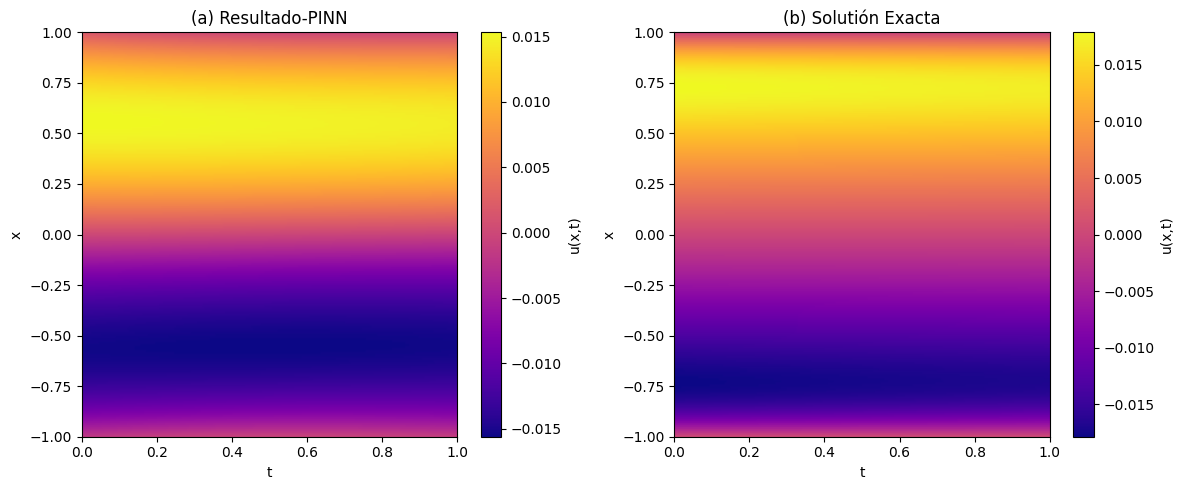

In [ ]:
# ------------------------------------------------------------
# Mapas 2-D comparativos (PINN vs. Solución exacta) - EN FILA
# ------------------------------------------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Malla densa (x,t) ----------------------------
n_x, n_t = 200, 200
x_grid = torch.linspace(-1, 1, n_x).reshape(-1, 1)
t_grid = torch.linspace(0, 1, n_t).reshape(1, -1)
X_torch, T_torch = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')

# ---------- 2. Evaluar PINN en toda la malla ----------------
with torch.no_grad():
    XT = torch.cat((X_torch.reshape(-1, 1), T_torch.reshape(-1, 1)), dim=1)
    U_pinn = model(XT[:, 0:1], XT[:, 1:2]).cpu().numpy().reshape(n_x, n_t)

# ---------- 3. Evaluar solución exacta ----------------------
X_np, T_np = X_torch.numpy(), T_torch.numpy()
U_exact = exact_solution(X_np, T_np)  # función predefinida

# ---------- 4. Gráfica en una sola FILA --------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# (a) PINN
im0 = axes[0].imshow(
    U_pinn,
    extent=(0, 1, -1, 1),
    origin='lower',
    aspect='auto',
    cmap='plasma'
)
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
axes[0].set_title('(a) Resultado-PINN')
plt.colorbar(im0, ax=axes[0], label='u(x,t)')

# (b) Exacta
im1 = axes[1].imshow(
    U_exact,
    extent=(0, 1, -1, 1),
    origin='lower',
    aspect='auto',
    cmap='plasma'
)
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
axes[1].set_title('(b) Solutión Exacta')
plt.colorbar(im1, ax=axes[1], label='u(x,t)')

plt.tight_layout()
plt.savefig("ResultadoPINNvsExactaEx2en2D.pdf", format="pdf")
#plt.suptitle('Comparación PINN vs. Solución exacta (Ecuación de Burgers)', fontsize=14)
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste para el título
plt.show()


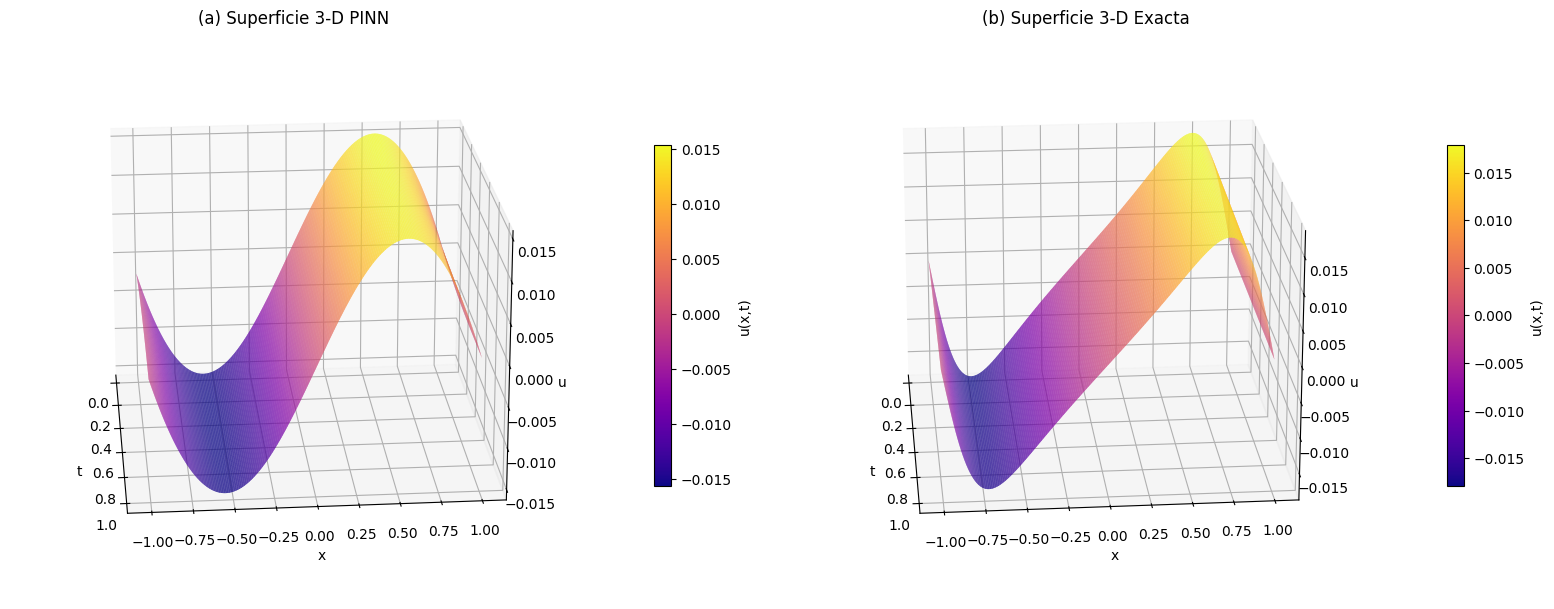

In [ ]:
# ------------------------------------------------------------
# Superficies 3-D comparativas (PINN vs. Exacta) - EN FILA
# ------------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------- Paso 1. Malla (x,t) ----------------------------
n_x, n_t = 200, 200
x_grid = torch.linspace(-1, 1, n_x).reshape(-1, 1)
t_grid = torch.linspace(0, 1, n_t).reshape(1, -1)
X_torch, T_torch = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')
X_np, T_np = X_torch.numpy(), T_torch.numpy()

# ---------- Paso 2. Evaluar PINN y solución exacta ---------
with torch.no_grad():
    XT = torch.cat((X_torch.reshape(-1, 1), T_torch.reshape(-1, 1)), dim=1)
    U_pinn = model(XT[:, 0:1], XT[:, 1:2]).cpu().numpy().reshape(n_x, n_t)

U_exact = exact_solution(X_np, T_np)  # Función predefinida

# ---------- Paso 3. Gráficas 3D en fila --------------------
fig = plt.figure(figsize=(16, 6))  # Ajusta el ancho para 2 gráficas

# (a) PINN
ax1 = fig.add_subplot(1, 2, 1, projection='3d')  # 1 fila, 2 columnas, posición 1
surf1 = ax1.plot_surface(
    T_np, X_np, U_pinn,
    cmap='plasma', edgecolor='none',
    rstride=1, cstride=1, antialiased=True
)
ax1.set_xlabel('t'); ax1.set_ylabel('x'); ax1.set_zlabel('u')
ax1.set_title('(a) Superficie 3-D PINN')
ax1.view_init(elev=20, azim=-5)  # Ángulo de vista
fig.colorbar(surf1, ax=ax1, shrink=0.6, pad=0.1, label='u(x,t)')

# (b) Exacta
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 1 fila, 2 columnas, posición 2
surf2 = ax2.plot_surface(
    T_np, X_np, U_exact,
    cmap='plasma', edgecolor='none',
    rstride=1, cstride=1, antialiased=True
)
ax2.set_xlabel('t'); ax2.set_ylabel('x'); ax2.set_zlabel('u')
ax2.set_title('(b) Superficie 3-D Exacta')
ax2.view_init(elev=20, azim=-5)
fig.colorbar(surf2, ax=ax2, shrink=0.6, pad=0.1, label='u(x,t)')
plt.tight_layout()
plt.savefig("ResultadoPINNvsExactaEx2en3D.pdf", format="pdf")
#plt.suptitle('Comparación PINN vs. Solución exacta (superficies 3-D)', fontsize=14)
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste para el título
plt.show()


> Otro gráfico opcional

In [ ]:
!pip -q install plotly
import plotly.graph_objs as go
fig = go.Figure(go.Surface(z=U, x=T, y=X, colorscale="Plasma"))
fig.update_layout(scene=dict(xaxis_title="t", yaxis_title="x", zaxis_title="u(x,t)"))
fig.show()